# Initialization

Run the following code to import the modules you'll need. After your finish the assignment, **remember to run all cells** and save the note book to your local machine as a PDF for gradescope submission.

In [1]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Download data

In this section we will download the data and setup the paths.


In [ ]:
# Download the data
if not os.path.exists('/content/aerialseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/aerialseq.npy -O /content/aerialseq.npy
if not os.path.exists('/content/antseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/antseq.npy -O /content/antseq.npy

# Q3: Affine Motion Subtraction

## Q3.1: Dominant Motion Estimation (15 points)

In [2]:
from scipy.interpolate import RectBivariateSpline

def LucasKanadeAffine(It, It1, threshold, num_iters):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param num_iters : (int), number of iterations for running the optimization

    :return: M       : (2, 3) The affine transform matrix
    """
    # Initial M
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])

    # ===== your code here! =====
    H, W = It.shape
    # Create a grid of (x,y) coordinates for the entire image (template)
    X, Y = np.meshgrid(np.arange(W), np.arange(H))
    X_flat = X.flatten()
    Y_flat = Y.flatten()
    
    # Create splines for interpolation on It and It1
    It_spline = RectBivariateSpline(np.arange(H), np.arange(W), It)
    It1_spline = RectBivariateSpline(np.arange(H), np.arange(W), It1)
    
    # Initialize the affine parameters: p = [p1, p2, p3, p4, p5, p6]
    # The affine warp is: W(x; p) = [ (1+p1)*x + p2*y + p3; p4*x + (1+p5)*y + p6 ]
    p_vec = np.zeros(6)
    
    for _ in range(num_iters):
        # Construct the current affine warp matrix from p_vec
        M = np.array([[1 + p_vec[0], p_vec[1], p_vec[2]],
                      [p_vec[3],     1 + p_vec[4], p_vec[5]]])
        
        # Warp the coordinates of the template using M
        X_warp = M[0, 0] * X_flat + M[0, 1] * Y_flat + M[0, 2]
        Y_warp = M[1, 0] * X_flat + M[1, 1] * Y_flat + M[1, 2]
        
        # Determine the valid coordinates that fall within the bounds of It1
        valid_idx = (X_warp >= 0) & (X_warp <= W - 1) & (Y_warp >= 0) & (Y_warp <= H - 1)
        if np.sum(valid_idx) == 0:
            break
        
        # Select only the valid points
        X_valid = X_flat[valid_idx]
        Y_valid = Y_flat[valid_idx]
        X_warp_valid = X_warp[valid_idx]
        Y_warp_valid = Y_warp[valid_idx]
        
        # Evaluate the warped image It1 at the valid warped coordinates
        I1_warp = It1_spline.ev(Y_warp_valid, X_warp_valid)
        # Evaluate the template image It at the valid coordinates (using interpolation)
        T_valid = It_spline.ev(Y_valid, X_valid)
        
        # Compute the error between the template and the warped image
        error = T_valid - I1_warp  # shape (num_valid,)
        
        # Compute the gradients of It1 at the warped coordinates
        I1_dx = It1_spline.ev(Y_warp_valid, X_warp_valid, dx=0, dy=1)
        I1_dy = It1_spline.ev(Y_warp_valid, X_warp_valid, dx=1, dy=0)
        
        # Compute the Jacobian of the warp with respect to the affine parameters for each valid pixel.
        # For a pixel (x, y), the Jacobian is:
        # [ x, y, 1, 0, 0, 0 ]
        # [ 0, 0, 0, x, y, 1 ]
        # Therefore, the steepest descent images are:
        # [ I1_dx*x, I1_dx*y, I1_dx, I1_dy*x, I1_dy*y, I1_dy ]
        A = np.vstack((I1_dx * X_valid,
                       I1_dx * Y_valid,
                       I1_dx,
                       I1_dy * X_valid,
                       I1_dy * Y_valid,
                       I1_dy)).T  # Shape: (num_valid, 6)
        
        # Solve for the parameter update dp such that A dp = error in a least-squares sense
        dp, _, _, _ = np.linalg.lstsq(A, error, rcond=None)
        
        # Update the affine parameters
        p_vec = p_vec + dp
        
        # Check for convergence
        if np.linalg.norm(dp) < threshold:
            # Update M one last time before breaking out
            M = np.array([[1 + p_vec[0], p_vec[1], p_vec[2]],
                          [p_vec[3],     1 + p_vec[4], p_vec[5]]])
            break
    # ===== End of code =====

    return M

## Debug Q3.1



Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. When you warp the source frame using the obtained transformation matrix, it should resemble the target frame.

Text(0.5, 1.0, 'Warped Source image')

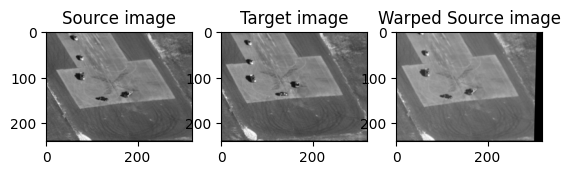

In [3]:
import cv2

num_iters = 100
threshold = 0.01
seq = np.load("aerialseq.npy")
It = seq[:,:,0]
It1 = seq[:,:,10]

# Source frame
plt.figure()
plt.subplot(1,3,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')

# Target frame
plt.subplot(1,3,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image')

# Warped source frame
M = LucasKanadeAffine(It, It1, threshold, num_iters)
warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
plt.subplot(1,3,3)
plt.imshow(warped_It, cmap='gray')
plt.title('Warped Source image')

# Q3.2: Moving Object Detection (10 points)

In [4]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
from scipy.ndimage import affine_transform
import scipy.ndimage
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param num_iters : (int), number of iterations for running the optimization
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: mask    : (H, W), the mask of the moved object
    """
    mask = np.ones(It.shape, dtype=bool)

    # ===== your code here! =====
        # Compute the dominant affine transformation matrix M using LucasKanadeAffine
    M = LucasKanadeAffine(It, It1, threshold, num_iters)
    
    # Warp image It to align with It1 using the computed affine transformation M.
    # Note: cv2.warpAffine expects the size in (width, height) order.
    H, W = It.shape
    It_warped = cv2.warpAffine(It, M, (W, H))
    
    # Compute the absolute difference between the warped image and It1.
    diff = np.abs(It1 - It_warped)
    
    # Threshold the difference to create a binary mask of moving regions.
    mask = diff > tolerance
    
    # Optionally, refine the mask using morphological operations:
    # Apply binary erosion followed by dilation to remove noise.
    mask = binary_dilation(binary_erosion(mask))
    # ===== End of code =====

    return mask


## Q3.3: Tracking with affine motion (10 points)

In [5]:
from tqdm import tqdm

def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param seq       : (H, W, T), sequence of frames
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: masks   : (T, 4) moved objects for each frame
    """
    H, W, N = seq.shape

    rects =[]
    It = seq[:,:,0]

    # ===== your code here! =====
    masks = []
    for i in tqdm(range(1, seq.shape[2])):
        It_current = seq[:, :, i-1]
        It_next = seq[:, :, i]
        current_mask = SubtractDominantMotion(It_current, It_next, num_iters, threshold, tolerance)
        masks.append(current_mask)
    # ===== End of code =====
    masks = np.stack(masks, axis=2)
    return masks

## Q3.3 (a) - Track Ant Sequence

In [6]:
seq = np.load("antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

100%|██████████| 124/124 [00:35<00:00,  3.46it/s]


Ant Sequence takes 35.958883 seconds


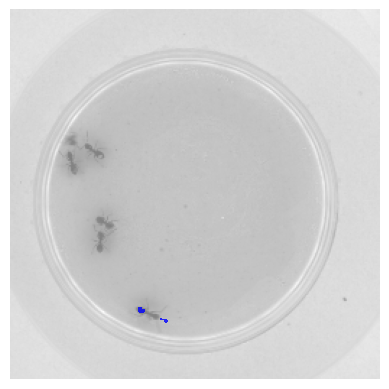

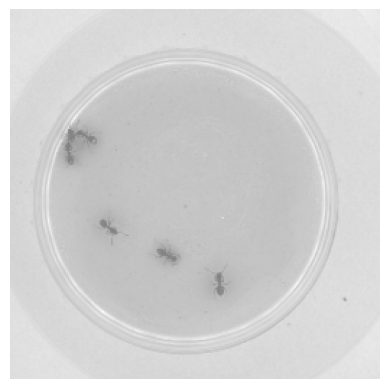

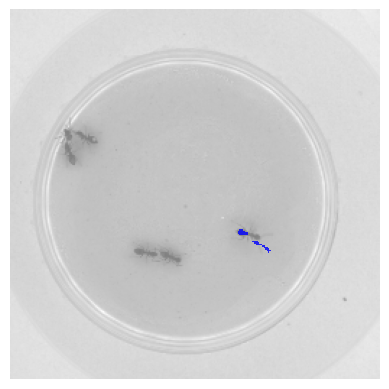

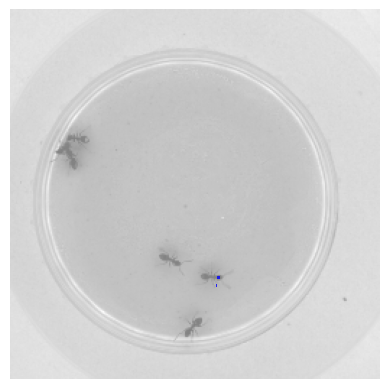

In [7]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')


### Q3.3 (b) - Track Aerial Sequence

In [8]:
seq = np.load("aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAerial Sequence takes %f seconds' % (toc - tic))

100%|██████████| 149/149 [01:22<00:00,  1.80it/s]


Aerial Sequence takes 82.882023 seconds


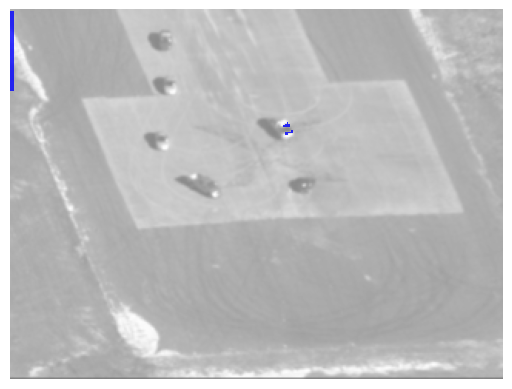

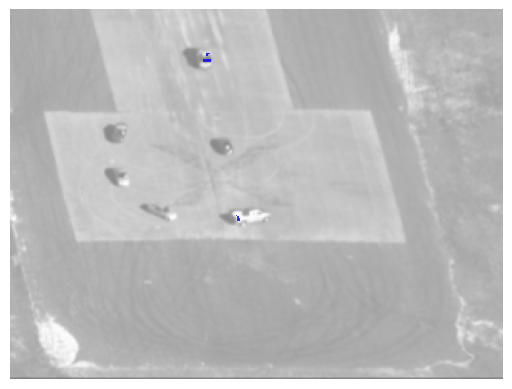

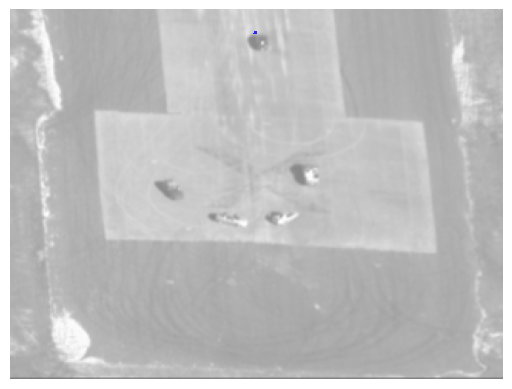

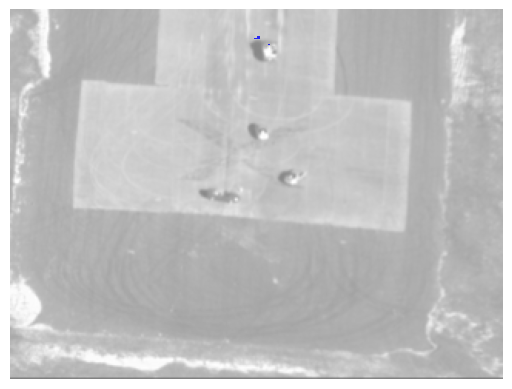

In [9]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')